# DiscoGAN-MNIST

* https://github.com/wiseodd/generative-models/blob/master/GAN/disco_gan/discogan_tensorflow.py
* rotated mnist to original mnist

이거 되고 나면 다른것도 해보자.

$$
\begin{align}
x_{AB}&=G_{AB}(X_a) \\
x_{ABA}&=G_{BA}(X_{AB}) \\
L_{CONST_A}&=d(x_{ABA}, x_A) \\
L_{GAN_B}&=-\mathbb E_{x_A}\left[ \log D_B(x_{AB}) \right]
\end{align}
$$

* domain A 에서 real_A 랑 fake_ABA (갔다 온거) 랑은 recon loss
* domain B 에서 fake_AB 랑 real_B 랑은 GAN loss

$$
\begin{align}
L_G&=L_{G_{AB}}+L_{G_{BA}} \\
&=L_{GAN_B}+L_{CONST_A}+L_{GAN_A}+L_{CONST_B} \\
\\
L_D&=L_{D_A}+L_{D_B}
\end{align}
$$

In [1]:
%matplotlib inline
import tensorflow as tf
import numpy as np
from tensorflow.examples.tutorials.mnist import input_data
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

slim = tf.contrib.slim

In [2]:
import sys
sys.path.insert(0, '../')
from utils import *

In [3]:
mnist = input_data.read_data_sets("../MNIST_data/", one_hot=True)

Extracting ../MNIST_data/train-images-idx3-ubyte.gz
Extracting ../MNIST_data/train-labels-idx1-ubyte.gz
Extracting ../MNIST_data/t10k-images-idx3-ubyte.gz
Extracting ../MNIST_data/t10k-labels-idx1-ubyte.gz


### Prepare data

In [4]:
import scipy

def rotate(x):
    x = x.reshape(-1, 28, 28)
    x = scipy.ndimage.interpolation.rotate(x, 90, axes=(1, 2))
    return x.reshape(-1, 28*28)

In [5]:
N = mnist.train.num_examples/2
train_A = mnist.train.images[:N]
train_B = rotate(mnist.train.images[N:])
# 100 test images for each domain
test_A = mnist.test.images[:100]
test_B = rotate(mnist.test.images[100:200])

In [6]:
train_A.shape, train_B.shape, test_A.shape, test_B.shape

((27500, 784), (27500, 784), (100, 784), (100, 784))

In [7]:
A_dim = B_dim = 784
h_dim = 128
z_dim = 64

In [8]:
def slog(x):
    """safe log for tf"""
    return tf.log(x+1e-8)

In [9]:
# D_A, D_b
def D(x, name, reuse=False):
    with tf.variable_scope(name, reuse=reuse):
        net = slim.fully_connected(x, h_dim)
        prob = slim.fully_connected(net, 1, activation_fn=tf.nn.sigmoid)
        return prob
    
# G_AB, G_BA
def G(x, op_size, name, reuse=False):
    with tf.variable_scope(name, reuse=reuse):
        net = slim.fully_connected(x, h_dim)
        prob = slim.fully_connected(net, op_size, activation_fn=tf.nn.sigmoid)
        return prob

In [10]:
# build nets
tf.reset_default_graph()

X_A = tf.placeholder(tf.float32, [None, A_dim])
X_B = tf.placeholder(tf.float32, [None, B_dim])

# A -> B.
## GAN loss
G_AB = G(X_A, B_dim, 'G_AB')
D_B_real = D(X_B, 'D_B')
D_B_fake = D(G_AB, 'D_B', reuse=True)

D_B_loss = -tf.reduce_mean(slog(D_B_real) + slog(1-D_B_fake)) # L_D_B
G_AB_loss = -tf.reduce_mean(slog(D_B_fake)) # L_GAN_B

## recon loss
G_ABA = G(G_AB, A_dim, 'G_BA')
# G_ABA_loss = tf.losses.mean_squared_error(G_ABA, X_A) # L_CONST_A
G_ABA_loss = tf.reduce_mean(tf.reduce_sum((G_ABA-X_A)**2, axis=1))

# B -> A.
G_BA = G(X_B, A_dim, 'G_BA', reuse=True)
D_A_real = D(X_A, 'D_A')
D_A_fake = D(G_BA, 'D_A', reuse=True)

D_A_loss = -tf.reduce_mean(slog(D_A_real) + slog(1-D_A_fake)) # L_D_A
G_BA_loss = -tf.reduce_mean(slog(D_A_fake)) # L_GAN_A

## recon loss
G_BAB = G(G_BA, B_dim, 'G_AB', reuse=True)
# G_BAB_loss = tf.losses.mean_squared_error(G_BAB, X_B) # L_CONST_B
G_BAB_loss = tf.reduce_mean(tf.reduce_sum((G_BAB-X_B)**2, axis=1))

G_loss = G_AB_loss + G_ABA_loss + G_BA_loss + G_BAB_loss
D_loss = D_A_loss + D_B_loss

G_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, scope='G_')
D_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, scope='D_')

G_train_op = tf.train.AdamOptimizer().minimize(G_loss, var_list=G_vars)
D_train_op = tf.train.AdamOptimizer().minimize(D_loss, var_list=D_vars)

[0/500] D_loss: 1.1038, G_loss: 53.2790


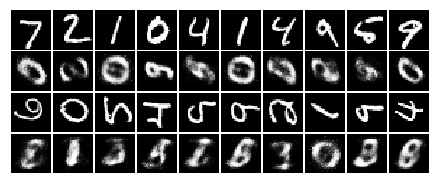

[10/500] D_loss: 0.7095, G_loss: 25.5264


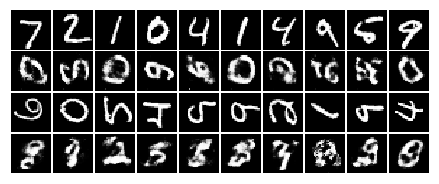

[20/500] D_loss: 1.0227, G_loss: 22.9020


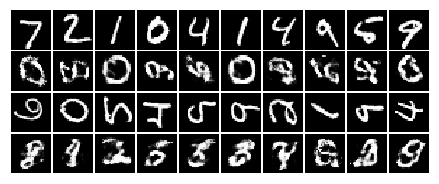

KeyboardInterrupt: 

In [11]:
# train model
sess = tf.Session()
sess.run(tf.global_variables_initializer())

n_epoch = 500
batch_size = 64

for epoch in range(n_epoch):
    np.random.shuffle(train_A)
    np.random.shuffle(train_B)
    for i in range(0, N, batch_size):
        batch_A = train_A[i:i+batch_size]
        batch_B = train_B[i:i+batch_size]
        _, G_loss_cur = sess.run([G_train_op, G_loss], {X_A: batch_A, X_B: batch_B})
        _, D_loss_cur = sess.run([D_train_op, D_loss], {X_A: batch_A, X_B: batch_B})

    if epoch % 10 == 0:
        # logging
        print('[{}/{}] D_loss: {:.4f}, G_loss: {:.4f}'.format(epoch, n_epoch, D_loss_cur, G_loss_cur))
            
        # plotting
        w = 10 # the number of test images
        samples_AB, samples_BA = sess.run([G_AB, G_BA], {X_A: test_A[:w], X_B: test_B[:w]})
        samples = np.concatenate([test_A[:w], samples_AB, test_B[:w], samples_BA], axis=0)
        fig = plot(samples, shape=(4,w))
    #     c = int((i+1) / print_step)
    #     fig.savefig('{}/{}_{:0>4d}.png'.format(op_dir, model.name, c), bbox_inches='tight')
        plt.show()
        plt.close(fig)

In [ ]:
A = test_A[40:60]
B = test_B[40:60]
samples_AB, samples_BA = sess.run([G_AB, G_BA], {X_A: A, X_B: B})
samples = np.concatenate([A, samples_AB, B, samples_BA], axis=0)
fig = plot(samples, shape=(4,A.shape[0]))

In [ ]:
A = train_A[40:60]
B = train_B[40:60]
samples_AB, samples_BA = sess.run([G_AB, G_BA], {X_A: A, X_B: B})
samples = np.concatenate([A, samples_AB, B, samples_BA], axis=0)
fig = plot(samples, shape=(4,A.shape[0]))